# Data analysis

The goal of this notebook is to analyze the timeseries and build a proof of concept for the forecast algorithm. We are interested in predicting one day at a time! We will start by importing and analyzing the data.

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import sys

sys.path.insert(0, "..")
from src import data, config, visualization, preprocessing, utils, models

/home/nchagnet/devs/tutorials/energy-demand-forecast/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
energy_df = data.load_full_data()

Most of the energy data is clean, though with some null values.

In [ ]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52658 entries, 2018-12-31 23:00:00+00:00 to 2025-01-03 00:00:00+00:00
Data columns (total 2 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Actual Total Load [MW] - France (FR)              52658 non-null  float64
 1   Day-ahead Total Load Forecast [MW] - France (FR)  52601 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB


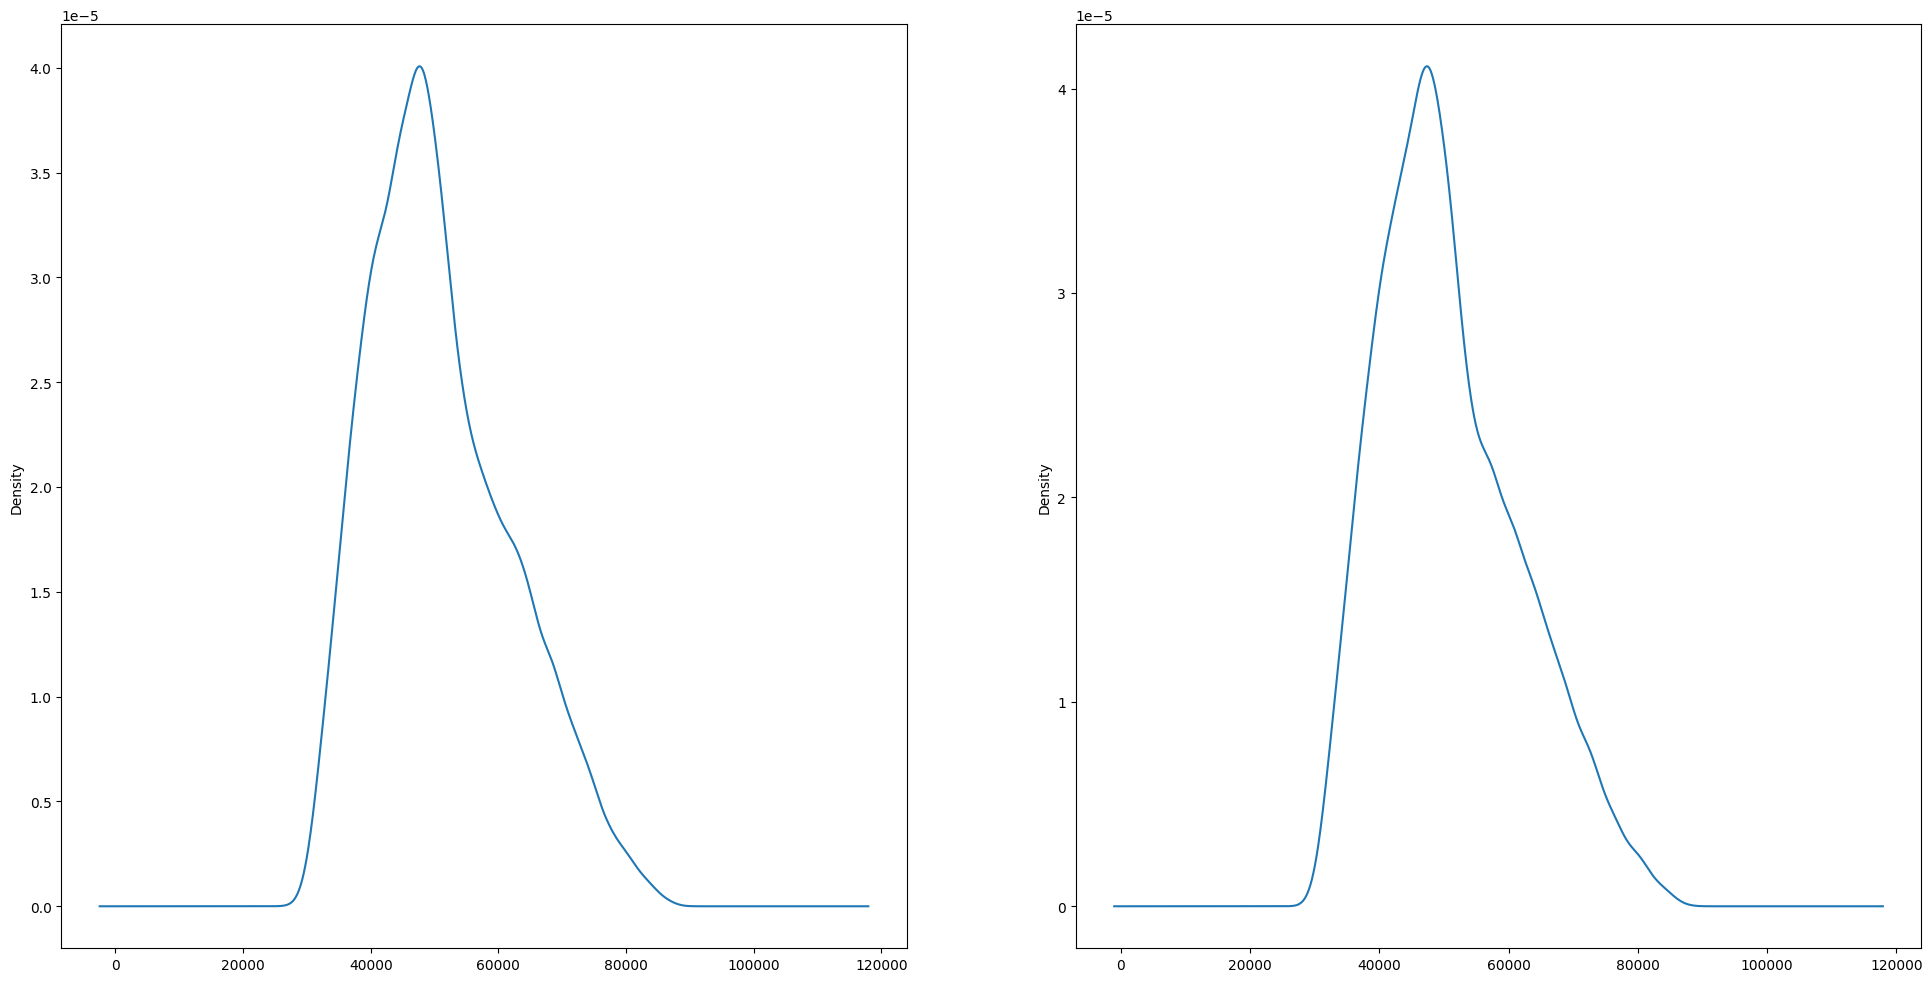

In [5]:
visualization.plot_distributions(energy_df.dropna())

In [6]:
# Useful index values
last_week = energy_df.index >= (energy_df.index[-1] - pd.Timedelta(weeks=1))
last_month = energy_df.index >= (energy_df.index[-1] - pd.Timedelta(weeks=4))
last_year = energy_df.index >= (energy_df.index[-1] - pd.Timedelta(days=365))

### Basic analysis and missing values

<Axes: xlabel='Time (UTC)'>

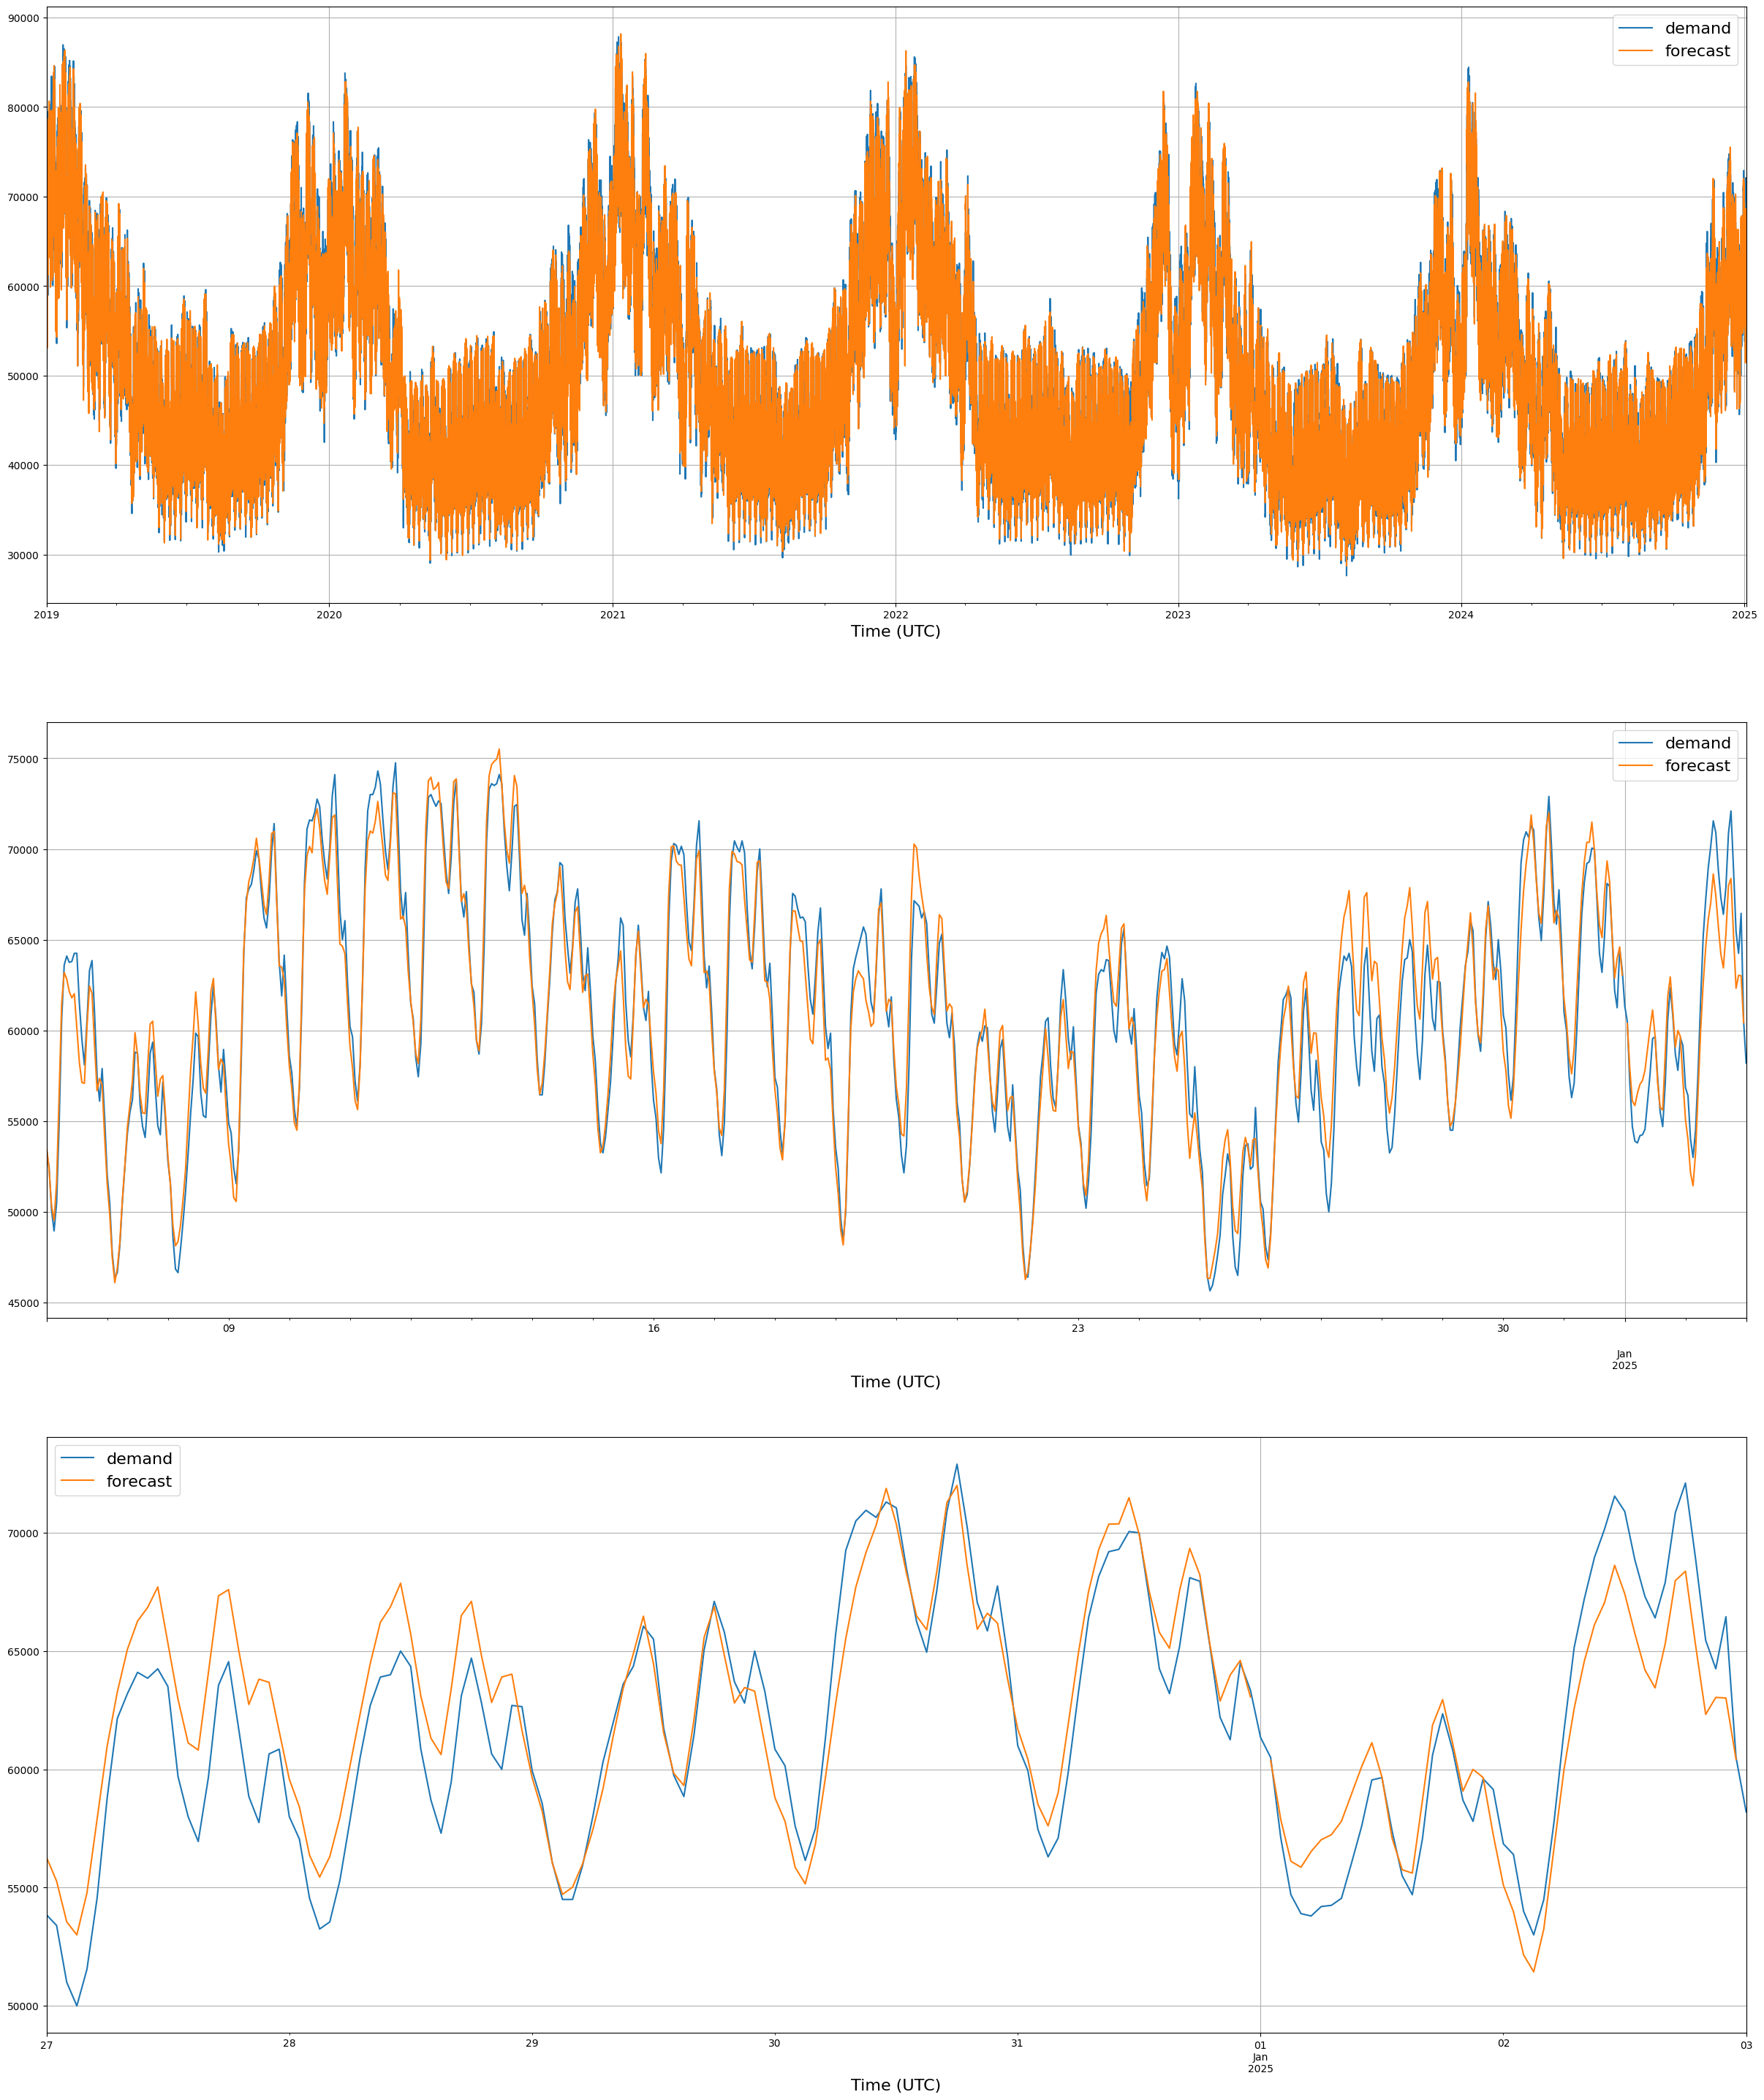

In [7]:
fig, axs = plt.subplots(nrows=3, figsize=(30, 12 * 3))
visualization.plot_series(energy_df[config.COL_ACTUAL], ax=axs[0], label="demand")
visualization.plot_series(energy_df[config.COL_FORECAST], ax=axs[0], label="forecast")

visualization.plot_series(energy_df.loc[last_month, config.COL_ACTUAL], ax=axs[1], label="demand")
visualization.plot_series(energy_df.loc[last_month, config.COL_FORECAST], ax=axs[1], label="forecast")

visualization.plot_series(energy_df.loc[last_week, config.COL_ACTUAL], ax=axs[2], label="demand")
visualization.plot_series(energy_df.loc[last_week, config.COL_FORECAST], ax=axs[2], label="forecast")

We fill null values using linear interpolation since the null values never account for more than a few hours in a row.

In [8]:
energy_df_2 = energy_df.copy()
load_actual_nans = energy_df_2.loc[energy_df_2[config.COL_ACTUAL].isna(), config.COL_ACTUAL]
load_forecast_nans = energy_df_2.loc[energy_df_2[config.COL_FORECAST].isna(), config.COL_FORECAST]
display(load_actual_nans)
display(load_forecast_nans)
for col in energy_df.columns:
    energy_df[col] = preprocessing.LinearlyInterpolateTS().apply(energy_df[col])

Series([], Name: Actual Total Load [MW] - France (FR), dtype: float64)

Time (UTC)
2019-04-15 09:00:00+00:00   NaN
2019-04-15 10:00:00+00:00   NaN
2019-07-25 00:00:00+00:00   NaN
2019-07-25 01:00:00+00:00   NaN
2019-07-25 02:00:00+00:00   NaN
2019-07-25 03:00:00+00:00   NaN
2019-07-25 04:00:00+00:00   NaN
2019-10-27 00:00:00+00:00   NaN
2020-10-25 00:00:00+00:00   NaN
2020-12-07 11:00:00+00:00   NaN
2021-01-03 22:00:00+00:00   NaN
2021-02-24 08:00:00+00:00   NaN
2021-05-12 08:00:00+00:00   NaN
2021-05-19 04:00:00+00:00   NaN
2021-06-03 16:00:00+00:00   NaN
2021-10-31 00:00:00+00:00   NaN
2021-10-31 01:00:00+00:00   NaN
2021-11-17 10:00:00+00:00   NaN
2021-11-18 10:00:00+00:00   NaN
2022-01-10 10:00:00+00:00   NaN
2022-01-10 11:00:00+00:00   NaN
2022-01-10 12:00:00+00:00   NaN
2022-01-10 13:00:00+00:00   NaN
2022-01-10 14:00:00+00:00   NaN
2022-01-10 15:00:00+00:00   NaN
2022-01-12 08:00:00+00:00   NaN
2022-01-17 12:00:00+00:00   NaN
2022-01-19 07:00:00+00:00   NaN
2022-01-19 08:00:00+00:00   NaN
2022-01-27 20:00:00+00:00   NaN
2022-01-28 00:00:00+00:00   N

### Seasonality

We can find the seasonality of the timeseries by looking at its Fourier transform and the power density for each Fourier components (a *periodogram*). From this plot, we see a twice-daily seasonality (indicator of night and day patterns), a daily seasonality (daily pattern of energy demand), a weekly seasonality, and finally yearly and biannual period.

Periods in hours: [8.7600e+03 2.4000e+01 4.3800e+03 1.2000e+01 1.6800e+02 1.0950e+03
 1.6700e+02 2.6281e+04 8.4000e+01 1.7520e+03 8.7600e+02 1.2510e+03
 1.4600e+03 9.7300e+02 1.3140e+04]
Periods in days: [3.650e+02 1.000e+00 1.830e+02 1.000e+00 7.000e+00 4.600e+01 7.000e+00
 1.095e+03 3.000e+00 7.300e+01 3.700e+01 5.200e+01 6.100e+01 4.100e+01
 5.480e+02]


<Axes: title={'center': 'Periodogram'}, xlabel='Frequencies', ylabel='Variance'>

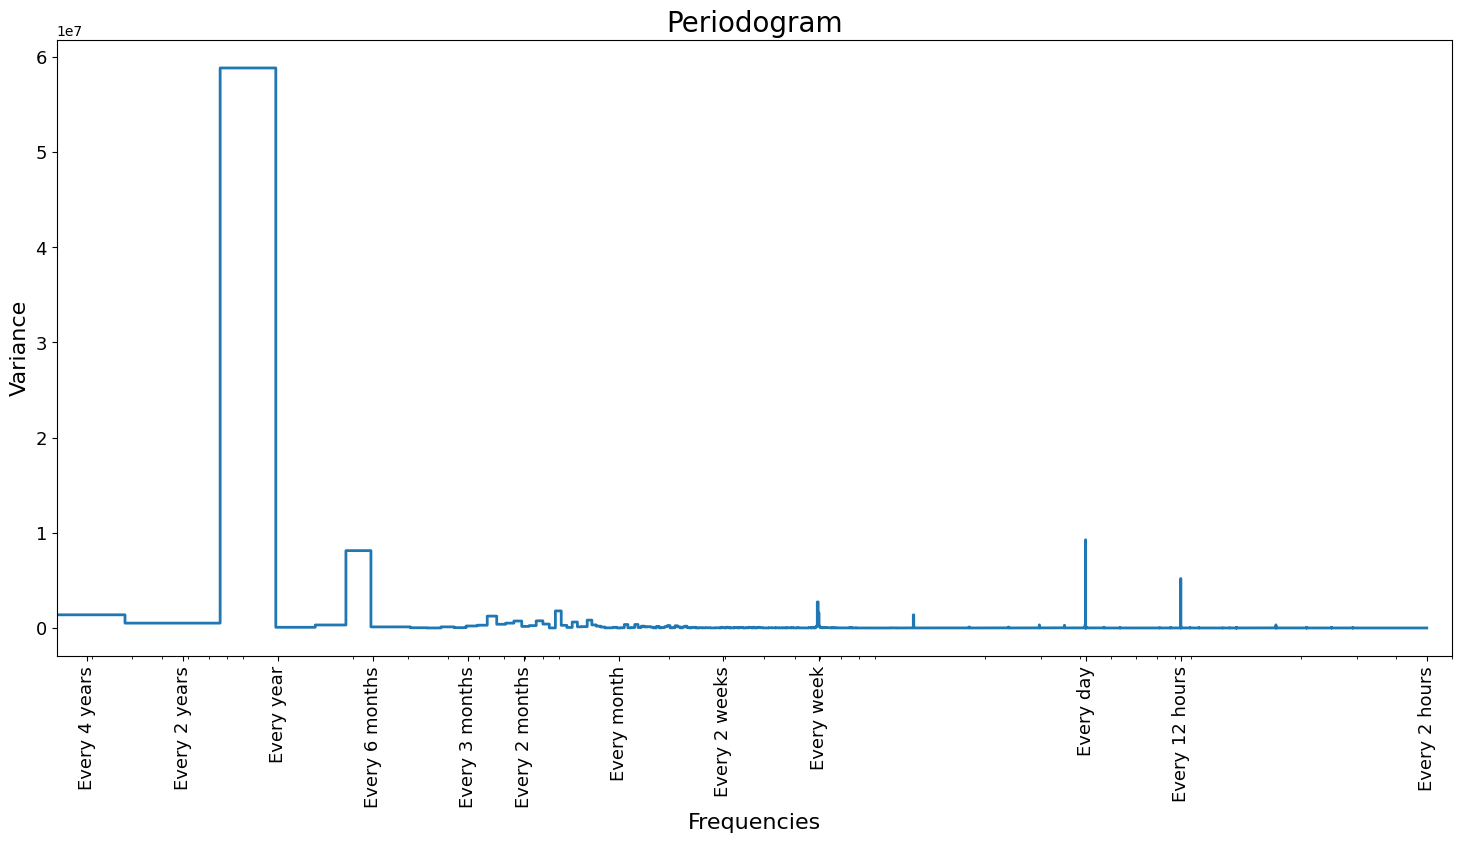

In [9]:
y = energy_df[config.COL_ACTUAL]
idx_probe = pd.date_range(y.index.max() - pd.Timedelta(days=365 * 3), y.index.max(), freq="h")
frequencies, spectrum, max_periods, max_spectrum = utils.compute_periodogram(y.loc[idx_probe], 15)
print(f"Periods in hours: {max_periods.round()}")
print(f"Periods in days: {(max_periods/24).round()}")
fig, ax = plt.subplots(figsize=(18, 8))
visualization.plot_periodogram(frequencies, spectrum, ax=ax)

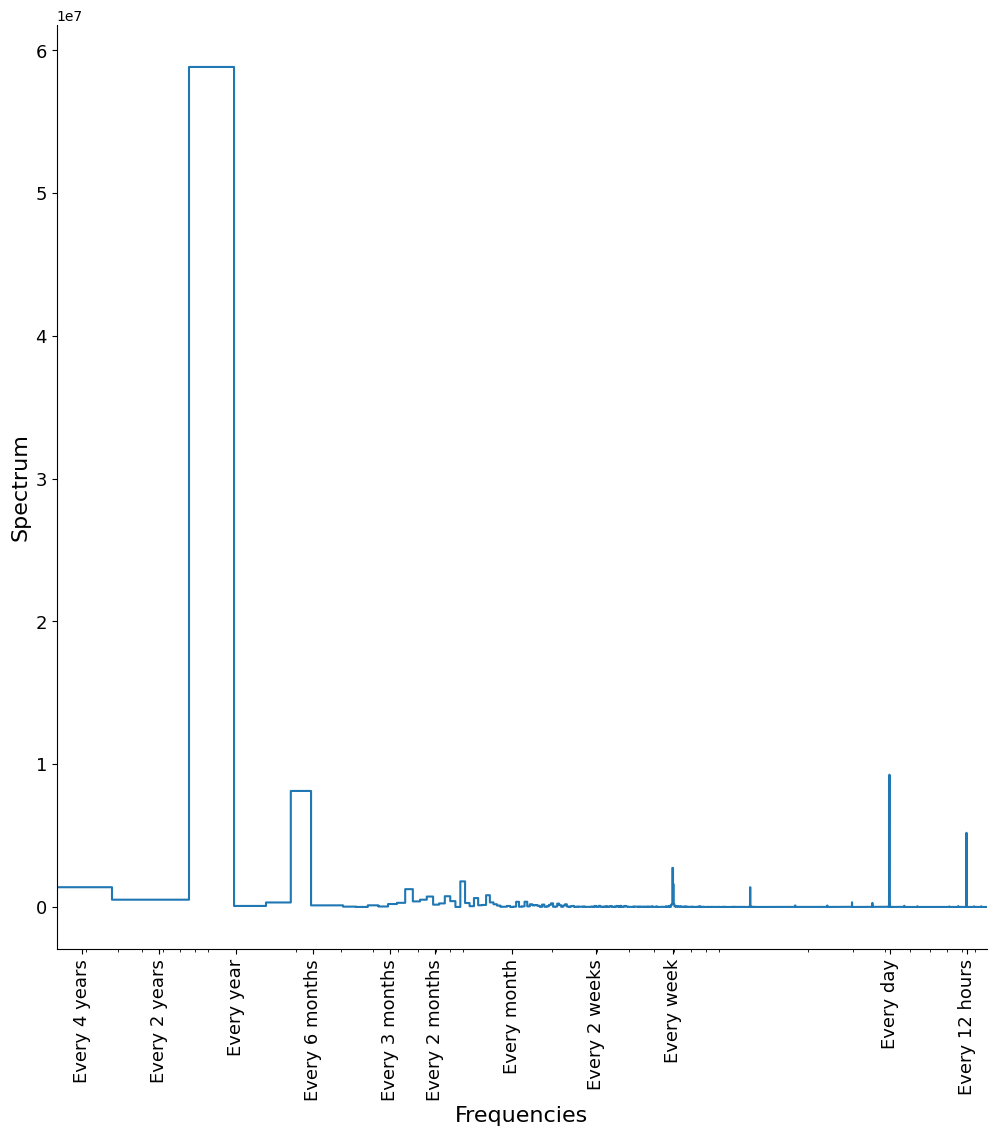

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.step(frequencies, spectrum)
ax.set_xscale("log")
day_hours = 24
week_day = 7
month_day = 30
year_month = 12

font = {
    "weight": "normal",
    "size": 16,
}

times = {
    "4 years": 4 * year_month * month_day * day_hours,
    "2 years": 2 * year_month * month_day * day_hours,
    "year": year_month * month_day * day_hours,
    "6 months": month_day * day_hours * 6,
    "3 months": month_day * day_hours * 3,
    "2 months": month_day * day_hours * 2,
    "month": month_day * day_hours,
    "2 weeks": 2 * week_day * day_hours,
    "week": week_day * day_hours,
    "day": day_hours,
    "12 hours": 12,
    # "2 hours": 2,
}
ax.set_xlim(0.8 / max(times.values()), 1.2 / min(times.values()))
ax.set_xticks([1.0 / time for time in times.values()])
ax.set_xticklabels([f"Every {key}" for key in times.keys()], rotation=90)
ax.tick_params(axis="both", labelsize=13)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_ylabel("Spectrum", fontdict=font)
ax.set_xlabel("Frequencies", fontdict=font)
# ax.set_title("Periodogram", fontdict=dict(fontsize=20))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)

In [14]:
fig.savefig("../figs/periodogram.png", dpi=300, bbox_inches="tight")

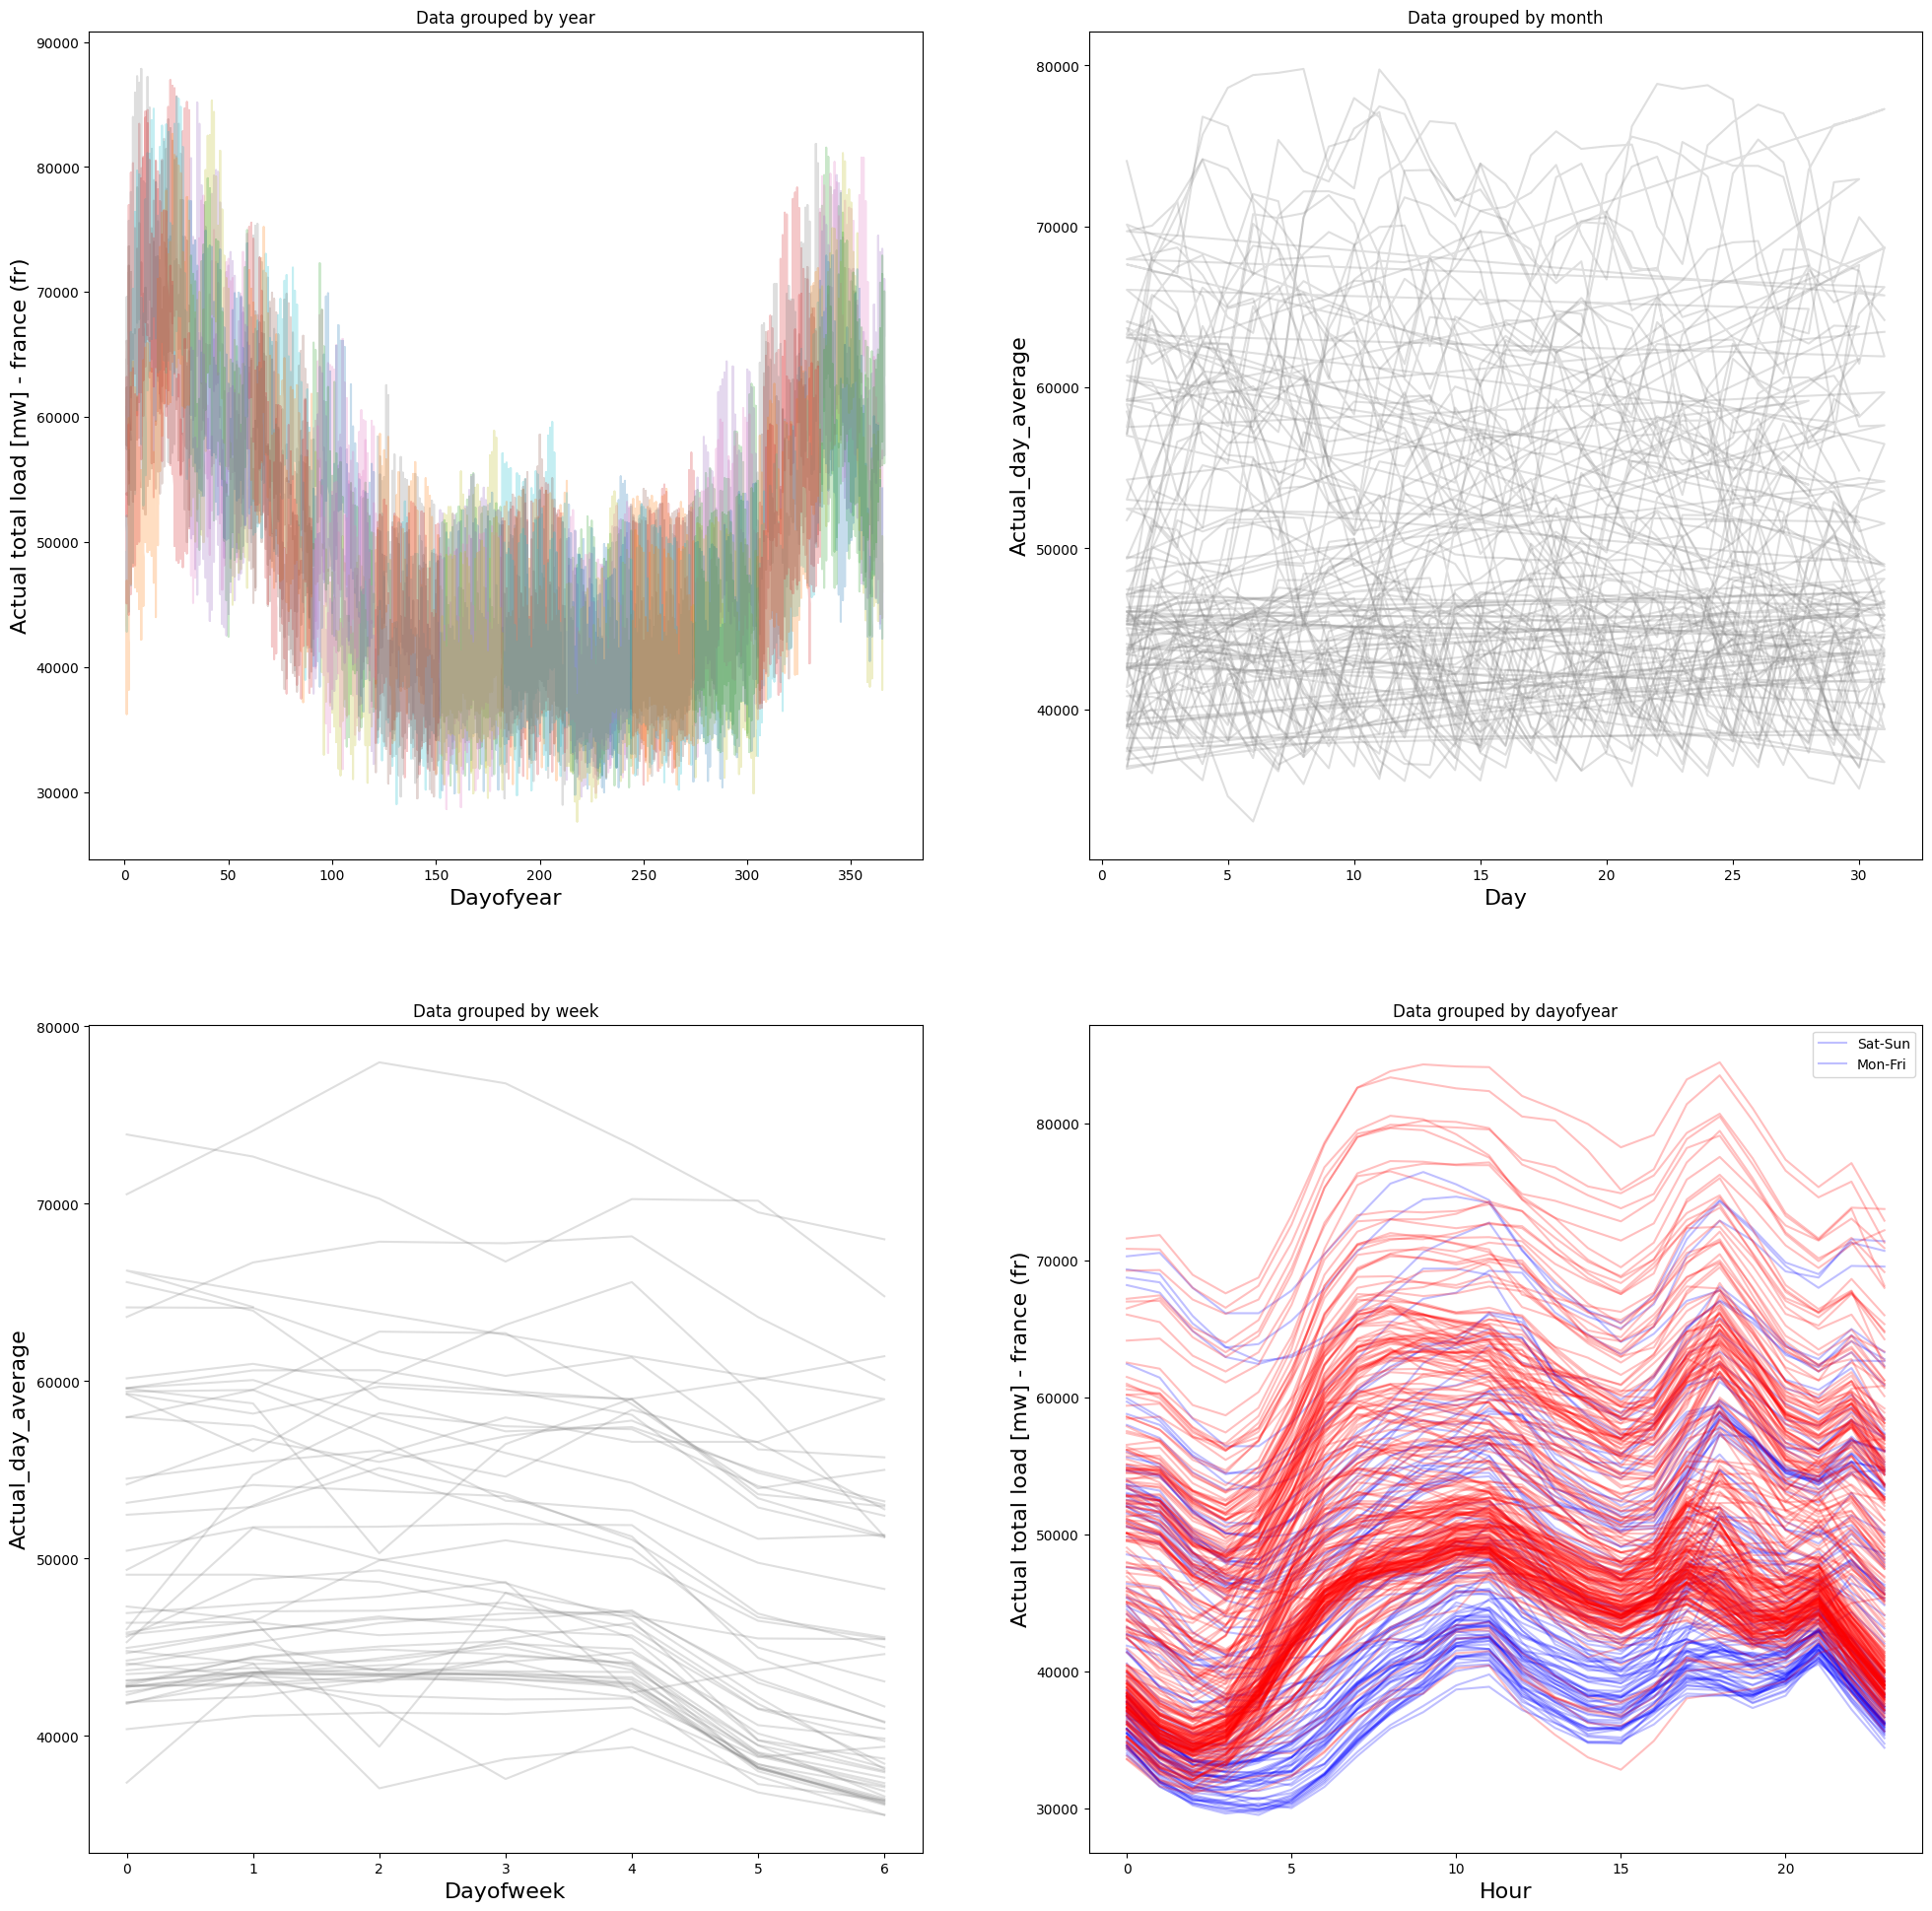

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24, 24))
axs = axs.ravel()
df = pd.DataFrame(y)
df["month"] = df.index.month
df["year"] = df.index.year
df["week"] = df.index.isocalendar().week
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["day"] = df.index.day
df["dayofyear"] = df.index.dayofyear
df["is_weekend"] = df.index.dayofweek.isin([5, 6])
df["actual_day_average"] = df.groupby(["day", "month", "year"])[config.COL_ACTUAL].transform("mean")
df = df.reset_index(drop=True)
visualization.plot_superimposed(df, x="dayofyear", y=config.COL_ACTUAL, group="year", hue="month", ax=axs[0])
visualization.plot_superimposed(df, x="day", y="actual_day_average", group="month", hue="gray", ax=axs[1])
visualization.plot_superimposed(
    df.loc[(df["year"] == 2024)],
    x="dayofweek",
    y="actual_day_average",
    group="week",
    hue="gray",
    ax=axs[2],
)
visualization.plot_superimposed(
    df.loc[(df["year"] == 2024) & df["is_weekend"]],
    x="hour",
    y=config.COL_ACTUAL,
    group="dayofyear",
    hue="blue",
    ax=axs[3],
)
visualization.plot_superimposed(
    df.loc[(df["year"] == 2024) & ~df["is_weekend"]],
    x="hour",
    y=config.COL_ACTUAL,
    group="dayofyear",
    hue="red",
    ax=axs[3],
)

axs[3].legend(["Sat-Sun", "Mon-Fri"])

axs = axs.reshape((2, 2))

From the partial correlation plot, we see the first three lags are correlated with the output so we will include them as features.

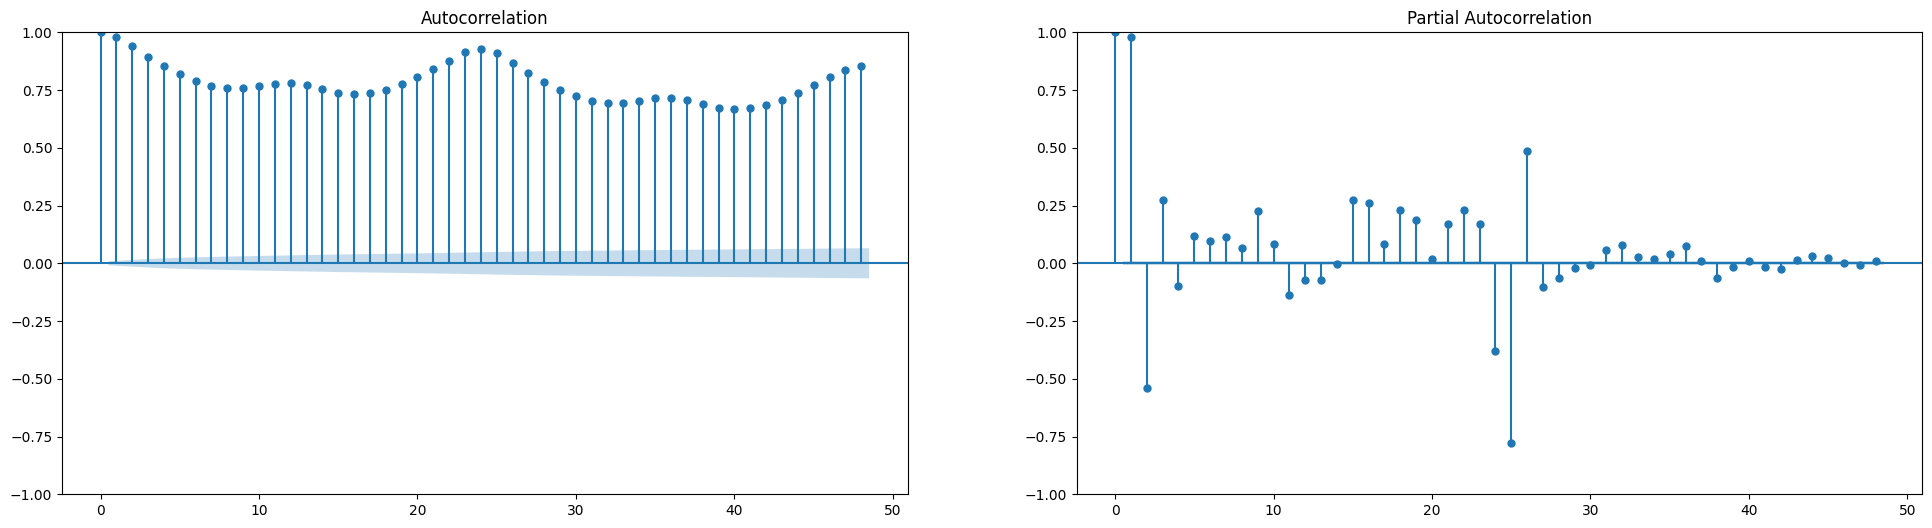

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(ncols=2, figsize=(24, 6))

_ = plot_acf(y, ax=axs[0])
_ = plot_pacf(y, ax=axs[1])